In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Player(object):
    def __init__(self, currentSum, usableAce, dealersCard):
        self.currentSum = currentSum # 현재 카드합
        self.dealersCard = dealersCard # 딜러의 카드
        self.usableAce = usableAce # 소프트/하드
        self.usingAce = self.usableAce # 에이스 카드가 있는지

    def ReceiveCard(self, card):
        if self.usingAce and self.currentSum + card > 21: # 에이스가 있고 21 이상인 경우 에이스를 1로 판단
            self.usingAce = False
            self.currentSum += card - 10
        else:
            self.currentSum += card

    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)

    def GetValue(self):
        return self.currentSum

    def ShouldHit(self, policy):
        return policy[self.GetState()]

    def Bust(self):
        return self.GetValue() > 21

In [32]:
class Dealer(object):
    def __init__(self, cards):
        self.cards = cards

    def ReceiveCard(self, card):
        self.cards.append(card)

    def GetValue(self):
        currentSum = 0
        aceCount = 0

        for card in self.cards: # 에이스 카드를 고려해서 유리한 숫자합을 구성
            if card == 1:
                aceCount += 1
            else:
                currentSum += card

        while aceCount > 0:
            aceCount -= 1
            currentSum += 11

            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount
                break

        return currentSum

    def ShouldHit(self):
        if self.GetValue() >= 17:
            return False
        else:
            return True

    def Bust(self):
        return self.GetValue() > 21

In [33]:
class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = [ ]
        self.stateActionMap = set()

    def AddPair(self, pair): # 새로운 조합을 추가
        if pair in self.stateActionMap:
            return
        
        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)

In [40]:
def EvaluateAndImprovePolicy(qMap, policy, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        qMap[pair] = qMap[pair] + ((reward - qMap[pair]) / returns[pair]) # qmap을 통해 가치합수 업데이트

        state = pair[0]
        shouldHit = False

        if qMap[(state, 1)] > qMap[(state, 0)]:
            if qMap[(state, 2)] > qMap[(state, 1)]:
                shouldHit = 2
            else : 
                shouldHit = 1

        policy[state] = shouldHit

def newCard():
    card = np.random.randint(1, 14)

    if card > 9:
        return 10
    else:
        return card

In [55]:
def PlayEpisode(qMap, policy, returns): # 게임 진행 룰 함수
    playerSum = np.random.randint(11, 22)
    dealerOpenCard = np.random.randint(1, 11)
    usableAce = bool(np.random.randint(0, 2))
    bet = 1

    player = Player(playerSum, usableAce, dealerOpenCard)
    dealer = Dealer([dealerOpenCard])

    stateActionInfo = StateActionInfo()
    hitAction = np.random.randint(0, 3)
    if hitAction == 2 : # 더블일 경우
        bet = 2
    stateActionInfo.AddPair((player.GetState(), hitAction)) # 랜덤으로 히트/스테이/더블

    if hitAction == 1:
        player.ReceiveCard(newCard())

        while not player.Bust() and player.ShouldHit(policy): # 버스트 되거나 17 이상이 될때까지 카드를 받음
            stateActionInfo.AddPair((player.GetState(), True))
            player.ReceiveCard(newCard())
            
    elif hitAction == 2: # 더블은 카드를 추가로 더 받을수 없음
        player.ReceiveCard(newCard())
        
        if not player.Bust() :
            stateActionInfo.AddPair((player.GetState(), True))
            player.ReceiveCard(newCard())

    if player.Bust():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -bet)
        return

    stateActionInfo.AddPair((player.GetState(), False))
    dealer.ReceiveCard(newCard())

    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(newCard())

    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, bet)
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -bet)
    else:
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 0)

In [59]:
qMap = { }
policy = { }
returns = { }

for playerSum in range(11, 22):
    for usableAce in range(2):
        for dealersCard in range(1, 11):
            playerState = (playerSum, bool(usableAce), dealersCard)
            qMap[(playerState, 0)] = 0
            qMap[(playerState, 1)] = 0
            qMap[(playerState, 2)] = 0
            returns[(playerState, 0)] = 0
            returns[(playerState, 1)] = 0
            returns[(playerState, 2)] = 0

            if playerSum == 20 or playerSum == 21:
                policy[playerState] = 0
            else:
                policy[playerState] = 1

for i in range(1000000):
    PlayEpisode(qMap, policy, returns)

x11 = [ ]
y11 = [ ]
x12 = [ ]
y12 = [ ]
x13 = [ ]
y13 = [ ]

x21 = [ ]
y21 = [ ]
x22 = [ ]
y22 = [ ]
x23 = [ ]
y23 = [ ]

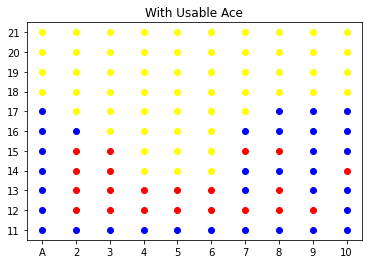

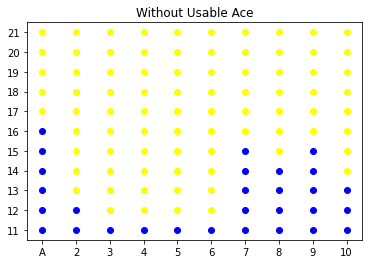

In [60]:
for playerState in policy:
    if playerState[1]:
        if policy[playerState] == 1:
            x11.append(playerState[2] - 1)
            y11.append(playerState[0] - 11)
        elif policy[playerState] == 0 :
            x12.append(playerState[2] - 1)
            y12.append(playerState[0] - 11)
        elif policy[playerState] == 2 :
            x13.append(playerState[2] - 1)
            y13.append(playerState[0] - 11)
    else:
        if policy[playerState] == 1:
            x21.append(playerState[2] - 1)
            y21.append(playerState[0] - 11)
        elif policy[playerState] == 0 :
            x22.append(playerState[2] - 1)
            y22.append(playerState[0] - 11)
        elif policy[playerState] == 2 :
            x23.append(playerState[2] - 1)
            y23.append(playerState[0] - 11)

plt.figure(0)
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.scatter(x13, y13, color='red')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.figure(1)
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.scatter(x23, y23, color='red')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.show()